# **AIR QUALITY PREDICTION**

**GOALS**
- Prepare Time Series Data
- Predicting NO2(GT) Readings with Linear Regression, AutoRegressive Models and ARIMA Models.

**Import necessary libraries**

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pytz
import time

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA


## PREPARE DATA

### IMPORT DATA

In [2]:


def wrangle(filepath):
    """Importing csv file, creating a new column 'Timestamp', concatenating 'Time' and 'Date' columns.
    Extract only two columns, 'Timestamp' and 'NO2(GT)'.

    Args:
        filepath (str): Path to the csv file.
    Returns:
        df (pd.DataFrame): DataFrame with two columns: 'Timestamp' and 'NO2(GT)'.
    """
    # Read csv file
    data = pd.read_csv(filepath)
    
    # Create a new column 'Timestamp' concatenating Date and Time columns
    data["Timestamp"] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    
    # Localize 'Timestamp' to CET timezone
    data["Timestamp"] = data["Timestamp"].dt.tz_localize('CET', ambiguous='NaT', nonexistent='NaT')
    
    # Extract new DataFrame with two columns 'Timestamp' and 'NO2(GT)'
    df = data[["Timestamp", "NO2(GT)"]].copy()
    
    # Set 'Timestamp' as the index
    df.set_index("Timestamp", inplace=True)
    
    # Drop null values
    df.dropna(inplace=True)
    
    return df



**Wrangle Function**
- The wrangle function localizes the Timezone to Central European Time(CET) since the dataset was originally collected in Italy, Milan.
- We also drop the null observations in our dataset.

In [3]:
# Use the wrangle function
filepath = "AirQualityUCI.csv"
df = wrangle(filepath)
print("df shape:", df.shape)
df.head()

df shape: (9357, 1)


,NO2(GT)
Timestamp,
2004-03-10 18:00:00+01:00,113.0
2004-03-10 19:00:00+01:00,92.0
2004-03-10 20:00:00+01:00,114.0
2004-03-10 21:00:00+01:00,122.0
2004-03-10 22:00:00+01:00,116.0


**Information of the dataset**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00+01:00 to 2005-04-04 14:00:00+02:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NO2(GT)  9357 non-null   float64
dtypes: float64(1)
memory usage: 146.2 KB


## **EXPLORE**

**Boxplot of NO2[GT]**

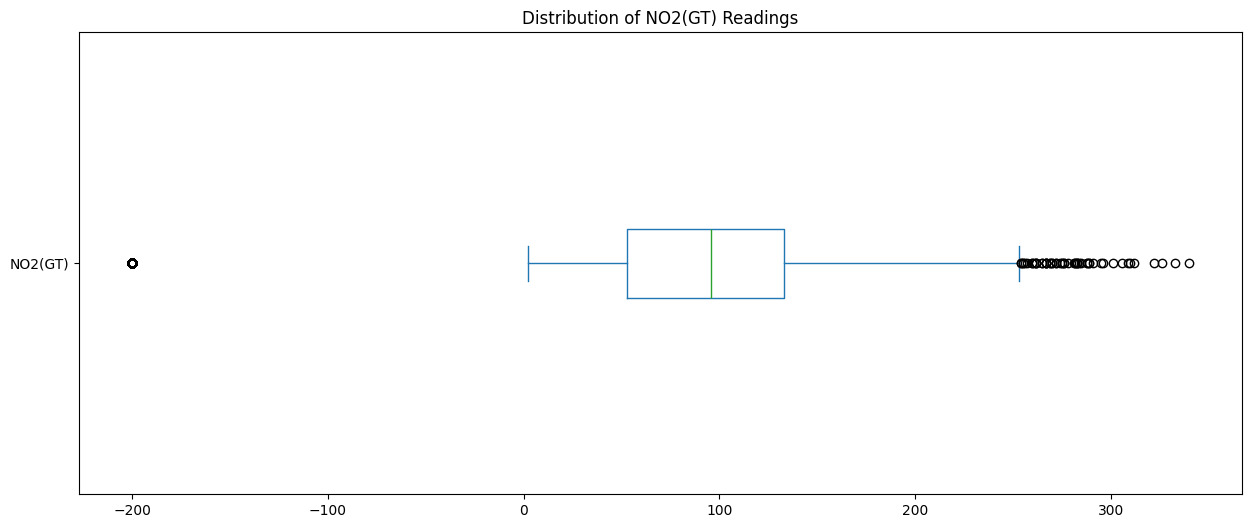

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
df["NO2(GT)"].plot(kind="box", vert=False, title="Distribution of NO2(GT) Readings", ax=ax);

**Outliers**

In [6]:
# Remove outliers
df = df[(df["NO2(GT)"] != -200) & (df["NO2(GT)"] <= 200)]

**Time Series Plot**

In [7]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

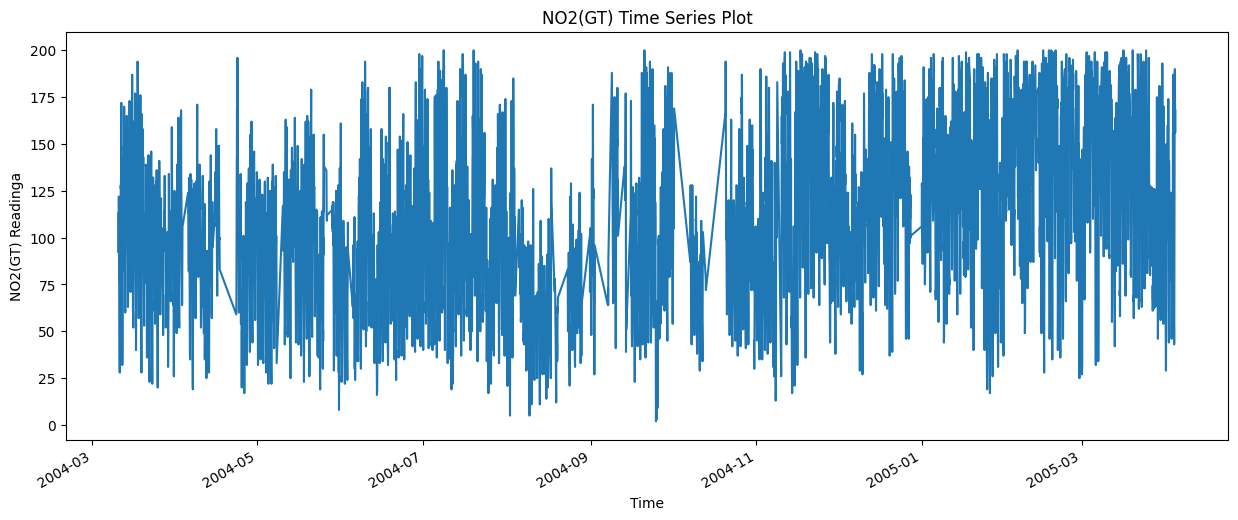

In [30]:
# Make Timestamp timezone-naive before plotting
df.index = df.index.tz_localize(None)

fig, ax = plt.subplots(figsize=(15, 6))
df["NO2(GT)"].plot(xlabel="Time", ylabel="NO2(GT) Readinga", title="NO2(GT) Time Series Plot", ax=ax);

**Resample Time Series**

Resampling the data to hourly cycles, enable us to capture fluctuations in our data, giving us insights.

In [28]:
df["NO2(GT)"].resample("h").mean().ffill().to_frame().head()

,NO2(GT)
Timestamp,
2004-03-10 18:00:00,113.0
2004-03-10 19:00:00,92.0
2004-03-10 20:00:00,114.0
2004-03-10 21:00:00,122.0
2004-03-10 22:00:00,116.0


**Rollling Average**

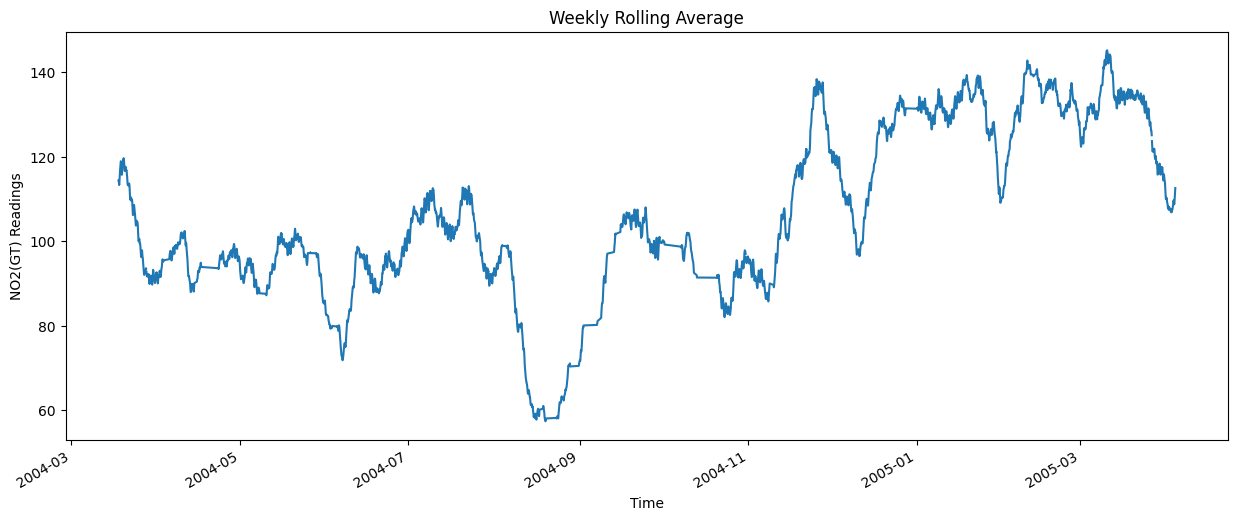

In [33]:
fig, ax, plt.subplots(figsize=(15,6))
df["NO2(GT)"].rolling(168).mean(1).plot(xlabel="Time", ylabel="NO2(GT) Readings", title="Weekly Rolling Average");

## **Linear Regression Model**

**Create Lag Feature**

In [69]:
df["NO2(GT).P1"] = df["NO2(GT)"].shift(1)
df.dropna()

,NO2(GT),NO2(GT).P1
Timestamp,,
2004-03-10 19:00:00,92.0,113.0
2004-03-10 20:00:00,114.0,92.0
2004-03-10 21:00:00,122.0,114.0
2004-03-10 22:00:00,116.0,122.0
2004-03-10 23:00:00,96.0,116.0
...,...,...
2005-04-04 10:00:00,190.0,187.0
2005-04-04 11:00:00,179.0,190.0
2005-04-04 12:00:00,175.0,179.0


Lag features will allow our model to consider past values as predictors for future outcomes.

**Heatmap Correlation**

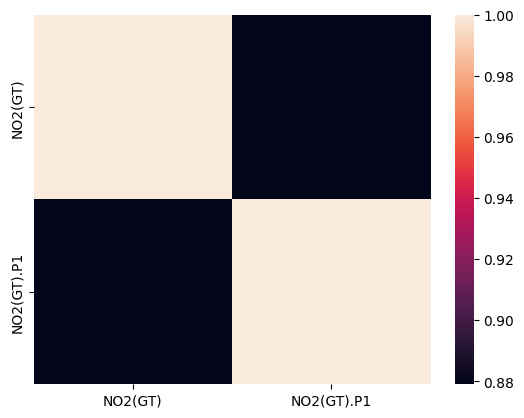

In [44]:
corr = df.corr()
sns.heatmap(corr);

**Autocorrelation Plot**

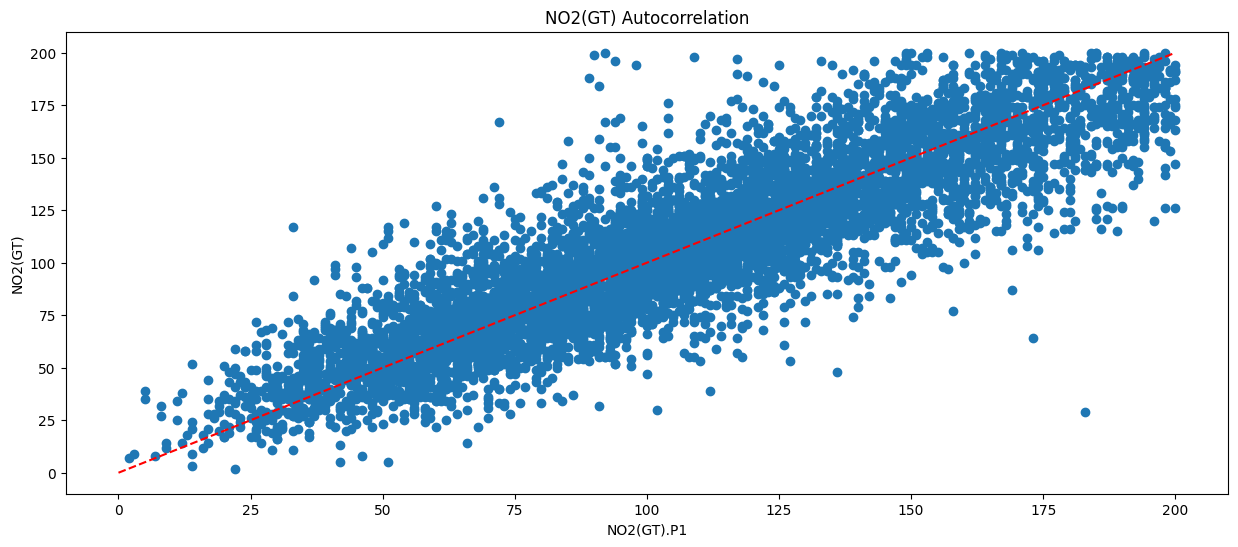

In [50]:
fig, ax, plt.subplots(figsize=(15, 6))
plt.scatter(x=df["NO2(GT).P1"], y=df["NO2(GT)"])
plt.plot([0, 200], [0, 200], linestyle="--", color="red")
plt.xlabel("NO2(GT).P1")
plt.ylabel("NO2(GT)")
plt.title("NO2(GT) Autocorrelation");

### **Split Data**

**Vertical Split**

In [71]:
df.dropna()
target = "NO2(GT)"
y = df[target]
X = df.drop(columns=target)

**Train Test Split**

Divide data into training and test sets

In [72]:
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5863, 1)
y_train shape: (5863,)
X_test shape: (1466, 1)
y_test shape: (1466,)


## **BUILD MODEL**

### Baseline

In [73]:
# Calculate mean for y_train
y_mean = y_train.mean()
print("Training Mean:", y_mean)

# Baseline
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Training MAE:", round(mae_baseline, 2))

Training Mean: 101.60463926317586
Training MAE: 31.98


### Iterate

In [76]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression())
model.fit(X_train, y_train)
model

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

## **EVALUATE**

In [82]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 14.26
Test MAE: 17.51


### Communicate Results

In [83]:
intercept = model.intercept_
coefficient = model.coef_
print(f"NO2(GT) = {intercept} + c{coefficient} * NO2(GT).P1")

AttributeError: 'Pipeline' object has no attribute 'intercept_'